In [659]:
import pandas as pd
import numpy as np
import math
import os

from PIL import Image


In [1085]:
# define filepaths
workspace = "/Users/advaysingh/Documents/projects/hindi_classification/" 
#print("Current workspace:", workspace) /Users/advaysingh/Documents/projects/hindi_classification/server/snapshot.png

data = os.path.join(workspace, 'data/Hindi/')


In [661]:
# create train/test dicts with files and labels

def create_dict(x: str) -> dict:
    x_dict = {}
    i = 0
    for dir in os.listdir(os.path.join(data, x)):
        for file in os.listdir(os.path.join(data, x, dir)):
            x_dict[os.path.join(data, x, dir, file)] = i
        i += 1
    return x_dict

# make pandas df

train_df = pd.DataFrame.from_dict(create_dict('Train'), orient='index')
test_df = pd.DataFrame.from_dict(create_dict('Test'), orient='index')

#print(train_df)
#df_temp = train_df[0].drop_duplicates()
# print(df_temp)

In [611]:
# Activations class
class Activation:
    # can add more types
    def __init__(self, act_type: str) -> None:
        self.act = act_type

    def print_act(self) -> None:
        return self.act
    
    def compute(self, z) -> list:

        # Sigmoid function
        if (self.act == 'sigmoid'):
            n = []
            for val in (z):
                n.append(1.0 / (1.0 + np.exp(val)))
            return n
        
        # ReLU function
        elif (self.act == 'relu'):
            vals = []
            for val in z:
                if val < 0.0:
                    vals.append(0.0)
                else:
                    vals.append(1.0)
            return vals

    def prime(self, z: list):

        # Sigmoid prime
        if (self.act == 'sigmoid'):
            sigs = self.compute(z)
            vals = []
            for val in sigs:
                vals.append(val * (1 - val))
            return vals
        
        # ReLU prime
        if (self.act == 'relu'):
            vals = []
            for val in z:
                if val == 0:
                    vals.append(0.0)
                else:
                    vals.append(1.0)
            return vals


def softmax(costs: list) -> list:
    exp_vals = []
    for cost in np.array(costs):
        exp_vals.append(np.exp(cost))
    return_vals = []
    for i in range(len(exp_vals)):
        return_vals.append(exp_vals[i] / sum(exp_vals))
    return return_vals

def softmax_prime(costs: list) -> list:
    softs = softmax(costs)
    vals = []
    for val in softs:
        vals.append(val * (1 - val))
    return vals

n = softmax([2, 3, 4])
print(n)

[0.09003057317038046, 0.24472847105479767, 0.6652409557748219]


In [1061]:
def activate(z: np.array) -> np.array:
    """Compute the sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def act_prime(z: np.array) -> np.array:
    """Compute the derivative of the sigmoid activation function."""
    ap = activate(z)
    return ap * (1 - ap)

def softmax(z: np.array) -> np.array:
    e_z = np.exp(z - np.max(z)) # Improved stability
    return e_z / e_z.sum(axis=0)

def softmax_prime(z: np.array) -> np.array:
    softmax_vals = softmax(z)
    # For each i, j in softmax output vector size: [si * (1 - si)] if i == j, otherwise: -si * sj
    return softmax_vals * (1 - softmax_vals)
    #return np.diag(softmax_vals) - np.outer(softmax_vals, softmax_vals)

class Model:
    def __init__(self, layers: list, load_perams: bool) -> None:
        self.train_df = train_df
        self.layers = layers

        self.all_weights = [None] * len(self.layers)
        self.all_bias = [None] * len(self.layers)

        # read in weights if load perams
        if (load_perams):
            layer = 0
            weightlist = os.listdir(os.path.join(workspace, 'data', 'Hyper_p/Weights'))
            for file in sorted(weightlist, key=lambda s: s.lower()):
                self.all_weights[layer] = (pd.read_csv(os.path.join(workspace, 'data', 'Hyper_p/Weights', file)).to_numpy())
                layer += 1
            layer = 0
            biaslist = os.listdir(os.path.join(workspace, 'data', 'Hyper_p/Biases'))
            for file in sorted(biaslist, key=lambda s: s.lower()):
                self.all_bias[layer] = (pd.read_csv(os.path.join(workspace, 'data', 'Hyper_p/Biases', file)).to_numpy())
                layer += 1

        else:
            for i in range(len(layers)):
                self.all_weights[i] = self.random_arrs(i)
                if i == 0:
                    self.all_bias[i] = np.random.uniform(low=-0.03125, high=0.03125, size=(self.layers[i],1))
                else:
                    bias_val = 0.5 # TODO reconsider
                    self.all_bias[i] = np.random.uniform(low=-bias_val, high=bias_val, size=(self.layers[i],1))
    

    def random_arrs(self, layer: int):
        if (layer == 0):
            return(np.random.uniform(low=-0.03125, high=0.03125, size=(self.layers[layer],1024)))
        else:
            weight_val = 1 / math.sqrt(self.layers[layer - 1])
            return(np.random.uniform(low=-weight_val, high=weight_val, size=(self.layers[layer], self.layers[layer-1])))

    def img_to_np(self, dir) -> np.array:
        return np.array(Image.open(dir)).flatten()
    
    def prop_forward(self, x: np.ndarray):
        activations = [x] #activations.size > zs
        zs = []
        for i in range(len(self.layers)):
            x = np.matmul(self.all_weights[i], x) + self.all_bias[i]
            zs.append(x)
            if (i == len(self.layers) - 1):
                x = softmax(x)
            else:
                x = activate(x)
            activations.append(x)
        return activations, zs


    
    def prop_backward(self, x_batch: np.ndarray, y_batch: np.ndarray):
        # Initialize gradients as zero
        delta_b_sum = [np.zeros(b.shape) for b in self.all_bias]
        delta_w_sum = [np.zeros(w.shape) for w in self.all_weights]

        # Loop over each example in the batch
        for x, y in zip(x_batch, y_batch):
            activations, zs = self.prop_forward(x)
            delta = (activations[-1] - y.reshape(46,1)) #* softmax_prime(zs[-1])

            # Gradients for output layer
            delta_b_sum[-1] += delta
            delta_w_sum[-1] += np.dot(delta, activations[-2].transpose())

            # Gradients for hidden layers
            for i in range(2, len(self.layers)):
                z = zs[-i]
                sp = act_prime(z)
                delta = np.dot(self.all_weights[-i + 1].transpose(), delta) * sp
                delta_b_sum[-i] += delta
                delta_w_sum[-i] += np.dot(delta, activations[-i - 1].T)

        # Average the gradients over the mini-batch
        num_examples = len(x_batch)
        delta_b_avg = [db_sum / num_examples for db_sum in delta_b_sum]
        delta_w_avg = [dw_sum / num_examples for dw_sum in delta_w_sum]

        # Return the average gradients
        return delta_w_avg, delta_b_avg
    
    def update_mini_batch(self, mini_batch, learning_rate):
        # aggregate gradients from the mini_batch
        delta_w, delta_b = self.prop_backward(mini_batch[0], mini_batch[1])
    
        # update weights and biases
        self.all_weights = [w - (learning_rate * dw) for w, dw in zip(self.all_weights, delta_w)] # todo change
        self.all_bias = [b - (learning_rate * db) for b, db in zip(self.all_bias, delta_b)] #todo change
    

    def train(self, X_train, y_train, epochs, learning_rate, mini_batch_size, test_df):
        n = len(X_train)

        # Convert to NumPy arrays if necessary
        X_train_np = np.array(X_train) if not isinstance(X_train, np.ndarray) else X_train
        y_train_np = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train
    
        for epoch in range(epochs):
            # Shuffle the training data for each epoch
            permutation = np.random.permutation(n)
            X_train_shuffled = X_train_np[permutation]
            y_train_shuffled = y_train_np[permutation]
        
            # Partition training data into mini-batches
            mini_batches = [
                (X_train_shuffled[k:k+mini_batch_size], y_train_shuffled[k:k+mini_batch_size])
                for k in range(0, n, mini_batch_size)
            ]
        
            # Update the model's weights with each mini-batch
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            
            if(epoch % 10 == 0 and epoch != 0):
                self.validate(test_df)

            new_loss = self.calc_squared_loss(X_train, y_train)
            print(f"Epoch {epoch}, mean squared loss: {new_loss}")
    
    

    def calc_squared_loss(self, X, y):
        squared_errors = []
        for i in range(len(X)):
            y_pred, _ = self.prop_forward(X[i].reshape(1024, 1))  # prop_forward should give the prediction
            squared_error = np.sum((y[i].reshape(46, 1) - y_pred[-1]) ** 2) / 2 
            squared_errors.append(squared_error)
        
        # Calculate mean squared error over all examples.
        mse = np.mean(squared_errors)
        return mse

    def pred(self, img: np.array):
        img, _ = self.prop_forward(img)
        #img, _ = self.prop_forward(np.array(img).reshape(len(img), 1))
        return (img[-1])
    
    def vals_for_softmax(self, index: int) -> np.array:
        """ Helper function to create softmax values"""
        vals = np.zeros(46)
        vals[index] = 1
        vals.reshape(46, 1)
        return vals
    
    def validate(self, test_df: pd.DataFrame) -> None:
        count, countright = 0, 0
        for img_dir, row in test_df.iterrows():
            img = np.array(Image.open(img_dir).convert("L").resize((32, 32))).flatten().reshape(1024, 1)
            outputs = self.pred(img)
            actual = self.vals_for_softmax(row[0])
            if (outputs.argmax() - actual.argmax() == 0):
                countright += 1
            count += 1
            accuracy = (float(countright) / float(count)) * 100
        print("count: ", count, ". Countright: ", countright, " Accuracy: ", accuracy, "%")

    def save(self) -> None:
        hp_data = '/Users/advaysingh/Documents/projects/hindi_classification/data/hyper_p'
        hp_data_biases, hp_data_weights = hp_data + '/Biases', hp_data + '/Weights'
        os.makedirs(hp_data)
        os.makedirs(hp_data_biases)
        os.makedirs(hp_data_weights)
        for layer in range(len(self.layers)):
            df_weights = pd.DataFrame(self.all_weights[layer])
            df_bias = pd.DataFrame(self.all_bias[layer])
            weights_file_name = "layer_" + str(layer) + "weights.csv"
            bias_file_name = "layer_" + str(layer) + "bias.csv"
            weights_file = open(os.path.join(hp_data_weights, weights_file_name), "x")
            bias_file = open(os.path.join(hp_data_biases, bias_file_name), "x")
            df_weights.to_csv(weights_file, index=False)
            df_bias.to_csv(bias_file, index=False)
    

In [1055]:
def vals_for_softmax(index: int) -> np.array:
        """ Helper function to create softmax values"""
        vals = np.zeros(46)
        vals[index] = 1
        vals.reshape(46, 1)
        return vals
test_df_sample = test_df.sample(500)


X_train, y_train = [], []
for img_dir, row in train_df.iterrows():
            X_train.append(np.array(Image.open(img_dir)).flatten().reshape(1024, 1))
            y_train.append(vals_for_softmax(row[0]))

In [1066]:

cnn = Model([300, 100, 46], True)
cnn.train(X_train, y_train, 5000, 0.1, 10000, test_df)

Epoch 0, mean squared loss: 0.1008997810717031
Epoch 1, mean squared loss: 0.10088992079146705
Epoch 2, mean squared loss: 0.10088122402015191
Epoch 3, mean squared loss: 0.10087904202445673
Epoch 4, mean squared loss: 0.10087230011486333
Epoch 5, mean squared loss: 0.10086892942108085
Epoch 6, mean squared loss: 0.10086229748003699
Epoch 7, mean squared loss: 0.10086022353643706
Epoch 8, mean squared loss: 0.10085563131693531
Epoch 9, mean squared loss: 0.1008519137114579
count:  13800 . Countright:  10749  Accuracy:  77.89130434782608 %
Epoch 10, mean squared loss: 0.10084801799422545
Epoch 11, mean squared loss: 0.10084390699967977
Epoch 12, mean squared loss: 0.10084229290853444
Epoch 13, mean squared loss: 0.10083575693980028
Epoch 14, mean squared loss: 0.10082885111734141
Epoch 15, mean squared loss: 0.10082644575775479
Epoch 16, mean squared loss: 0.10082196562514287
Epoch 17, mean squared loss: 0.10081506466347098
Epoch 18, mean squared loss: 0.10081175390487643
Epoch 19, mean

KeyboardInterrupt: 

In [1067]:
cnn.save()

In [1068]:
df_sample = train_df.sample(500)
cnn = Model([300, 100, 46], True)
cnn.validate(df_sample)

count:  500 . Countright:  438  Accuracy:  87.6 %


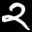

Predicted val:	2. Actual val: 	2


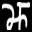

Predicted val:	jha. Actual val: 	jha


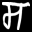

Predicted val:	ma. Actual val: 	ma


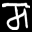

Predicted val:	ka. Actual val: 	ma


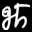

Predicted val:	jha. Actual val: 	jha


In [1109]:
sample_imgs = test_df.sample(5)
dict = pd.read_csv(os.path.join(workspace, 'data', 'dict.csv'))
for img_path, row in sample_imgs.iterrows():
    img = Image.open(img_path)
    display(img)
    img = (np.array(img)).flatten().reshape(1024, 1)
    predicted_val = dict.iloc[np.argmax(cnn.pred(img)) - 1, 1]
    actual_val = dict.iloc[row[0] - 1, 1]
    print('Predicted val:', predicted_val, '. Actual val: ', actual_val, sep='')

In [1110]:
import json
import time
from IPython.display import clear_output
import cv2

from PIL import Image

dict_lib = os.path.join(workspace, 'data/dict.csv')
img_path = os.path.join(workspace, 'server/snapshot.png')
out_file = os.path.join(workspace, 'server/outputs.json')

cnn = Model([300, 100, 46], True)
"""outs = cnn.pred(cnn.img_to_np(img_path))
index = outs.index(max(outs))
new_english_value = pd.read_csv(os.path.join(workspace, 'data', 'dict.csv'))[index][1]"""

def update_json_file(hindi_value, english_value):
    with open(out_file, 'r') as file:
        data = json.load(file)
    data['hindi'] = hindi_value
    data['english'] = english_value
    with open(out_file, 'w') as file:
        json.dump(data, file, indent=0)


# Updating based on the time
try:
    while True:
        try:
            # set img to Image or openCV package (both resulting in lossy conversions).
            img = Image.open(img_path).convert('L').resize((32, 32))
            #img = cv2.imread(img_path)
            #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            #img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_LANCZOS4) 
            display(img)
            clear_output(wait=True)
            img = np.array(img).flatten().reshape(1024, 1)
            if np.max(img) == 0:
                new_english_value = None; new_hindi_value = None
            else: 
                index = cnn.pred(img).argmax()
                new_english_value = str(pd.read_csv(dict_lib).iloc[index - 1, 1])
                new_hindi_value = str(pd.read_csv(dict_lib).iloc[index - 1, 2])

            update_json_file(new_hindi_value, new_english_value)

            
        except SyntaxError as e:
            print(f"An error occurred while processing the image: {e}")
            new_english_value = None  # Set a default value or handle differently
            new_hindi_value = None
        except Exception as e:
            # Optionally, catch and handle other non-SyntaxErrors if necessary
            print(f"An unexpected error occurred: {e}")
            new_english_value = None  # Set a default value or handle differently
            new_hindi_value = None
        
        # Print the new values (for debug purposes)
        # print(f'Updated JSON file with hindi: {new_hindi_value}, english: {new_english_value}')


        
        time.sleep(0.1)  # Wait for 0.1 seconds (same pace as server.js)
except KeyboardInterrupt:
    print("Update stopped by user.")

Update stopped by user.
